# Visualisation & Tables
This notebook uses the analysis functions found in `analysis.py` to calculate the coverages of the smoke in `dataset.json`. These are then used to produce the statistics/visualizations used within the results section of the report.

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import matplotlib.patches as mpatches
import matplotlib.colors as mcolours
import matplotlib.colorbar as mcolorbar
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy.stats as stats

from scipy import stats
from collections import Counter
from configparser import ConfigParser
import json
import seaborn as sns
import matplotlib.cm as cm
from prettytable.colortable import ColorTable, Theme
import numpy as np
from math import pi

from awpy.visualization.plot import plot_map, position_transform
from awpy.parser import DemoParser
from awpy.data import MAP_DATA

from analysis import load_doorway_data, load_smoke_data, assign_doorways

In [ ]:
config = ConfigParser()
config.read("data\\config.ini")

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Helvetica']
plt.rcParams.update({'font.size': 22})

In [ ]:
DEMO_DIR = config["Data"]["demo_directory"]
FIGURES_DIR = config["Data"]["demo_directory"] + "\\figures"
DATASET_FILE = "data\\dataset.json"

MAP_SCALE = MAP_DATA["de_mirage"]["scale"]
SMOKE_RADIUS_SCALED = float(config["Data"]["smoke_radius_units"]) / MAP_DATA["de_mirage"]["scale"]

GREEN_TABLE_THEME = Theme(
    default_color="92",
    vertical_color="34",
    horizontal_color="34",
    junction_color="92",
)

In [ ]:
red_val = float(config["Visualisation"]["red_coverage_threshold"])
orange_val = float(config["Visualisation"]["orange_coverage_threshold"])
green_val = float(config["Visualisation"]["green_coverage_threshold"])

cvals  = [red_val, orange_val, green_val]
colors = ["#FF5151","#FFC881","#73FA7E"]

tuples = list(zip(cvals, colors))

NORM=plt.Normalize(0,100)
COVERAGE_CMAP = mcolours.LinearSegmentedColormap.from_list("", tuples)


In [ ]:
def plot_all_smokes(rounds, map_name, map_type="simpleradar", dark=True):
    '''Simple function which plots all smokes thrown during a game on the minimap'''
    fig, a = plot_map(map_name=map_name, map_type=map_type, dark=dark)
    fig.set_size_inches(18.5, 10.5)
    smoke_colour = config["Visualisation"]["smoke_colour"]
    for r in rounds:
        for g in r["grenades"]:
            end_x = position_transform(map_name, g["grenadeX"], "x")
            end_y = position_transform(map_name, g["grenadeY"], "y")
            if g["grenadeType"] == "Smoke Grenade":
                smoke_circle = plt.Circle(
                    (end_x, end_y), SMOKE_RADIUS_SCALED, alpha=0.2, color=smoke_colour)
                a.add_artist(smoke_circle)
    plt.show()
    return fig

In [ ]:
def draw_introduction_figures():
    '''Generates the figures used in the introduction'''
    parser = DemoParser()
    inf_game = parser.read_json(
        json_path=DEMO_DIR + "\\misc\\introduction_demos\\natus-vincere-vs-g2-m1-inferno.json")
    mirage_game = parser.read_json(
        json_path=DEMO_DIR + "\\misc\\introduction_demos\\natus-vincere-vs-g2-m2-mirage.json")
    plot_all_smokes(inf_game["gameRounds"], "de_inferno")
    plot_all_smokes(mirage_game["gameRounds"], "de_mirage") 

In [ ]:
def transform(value, axis):
    '''Wrapper function to call the transform function from awpy with map set to mirage by default'''
    return position_transform("de_mirage", value, axis)

In [ ]:
def overlay_doorway_image(a, radius=False, fill=False):
    '''Draws figure to show location of manually collected doorways and their detection zones'''

    doorways = load_doorway_data()
    door_col = config["Visualisation"]["doorway_colour"]

    # Two iterations to ensure draw order is correct for alpha when overlapping
    if radius:
        for doorway in doorways:
            # Plots a circle representing the detection radius of the doorway
            mp_x_scaled = transform(doorway.midpoint.x, "x")
            mp_y_scaled = transform(doorway.midpoint.y, "y")
            detection_r = config["Data"]["detection_radius_units"]
            detection_r_scaled = int(detection_r) / MAP_SCALE
            
            if fill:
                a.add_artist(plt.Circle((mp_x_scaled, mp_y_scaled), detection_r_scaled, alpha=0.35, color=door_col, fill=True))
            else:
                a.add_artist(plt.Circle((mp_x_scaled, mp_y_scaled), detection_r_scaled, alpha=0.5, color=door_col, fill=False, linewidth = 3))

    # Plots a yellow line with shadow for each doorway
    for doorway in doorways:
        xs = [transform(doorway.vector1.x, "x"), transform(doorway.vector2.x, "x")]
        ys = [transform(doorway.vector1.y, "y"), transform(doorway.vector2.y, "y")]
        shadow = [path_effects.SimpleLineShadow(shadow_color="black", linewidth=8, 
            alpha=0.6, offset=(3, -3)),path_effects.Normal()]
        a.plot(xs, ys, color=door_col, linewidth=8, solid_capstyle='round', 
            path_effects=shadow)

    # Adds legend to show yellow lines are doorways
    doorway_rep = mpatches.Patch(color=door_col, label="Doorway")
    plt.legend(handles=[doorway_rep], prop={'size': 22}, loc='upper left')

def draw_door_image(radius=False, fill=False):
    fig, a = plot_map(map_name="de_mirage", map_type="simpleradar")
    fig.set_size_inches(15, 15)
    overlay_doorway_image(a, radius, fill)
    plt.show()

In [ ]:
def draw_abstract_representation(doorway, smoke, plot_radius=False):
        plt.rcParams.update({'font.size': 16})
        plt.rcParams['font.family'] = 'sans-serif'
        plt.rcParams['font.sans-serif'] = ['Helvetica']
        fig1 = plt.figure()
        fig1.set_size_inches(12, 12)
        ax1 = fig1.add_subplot(111, aspect='equal')

        spacing = 6

        # Plots the doorway
        x_values = [doorway.vector1.x, doorway.vector2.x]
        y_values = [doorway.vector1.y, doorway.vector2.y]
        ax1.plot(x_values, y_values, 'bo', linestyle='dashed')
        ax1.text(doorway.vector1.x + spacing, doorway.vector1.y,
                 f"D1\n({doorway.vector1.x}, {doorway.vector1.y})", horizontalalignment='left',
                 verticalalignment='center')
        ax1.text(doorway.vector2.x + spacing, doorway.vector2.y,
                 f"D2\n({doorway.vector2.x}, {doorway.vector2.y})", horizontalalignment='left',
                 verticalalignment='center')

        # Plots the radius line
        if plot_radius:
            x_values = [smoke.vector.x, smoke.vector.x-smoke.radius]
            y_values = [smoke.vector.y, smoke.vector.y]
            ax1.plot(x_values, y_values, marker="o",
                     color='grey', linestyle="solid")
            ax1.text(smoke.vector.x - smoke.radius/2, smoke.vector.y - spacing*2,
                     f"Smoke radius\n({smoke.radius} units)", horizontalalignment='center',
                     verticalalignment='center')

        # Plots the smoke
        plt.plot(smoke.vector.x, smoke.vector.y, marker="o", markersize=5, markeredgecolor="black",
                 markerfacecolor="black")

        smoke_circle = plt.Circle(
            (smoke.vector.x, smoke.vector.y), smoke.radius, alpha=1, color="black", linewidth=4, fill=False)
        ax1.text(smoke.vector.x, smoke.vector.y+spacing*2, f"Smoke\n({smoke.vector.x}, {smoke.vector.y})", horizontalalignment='center',
                 verticalalignment='center')

        ax1.add_patch(smoke_circle)
        ax1.autoscale_view()

In [ ]:
def draw_representation_cases():
    '''Draws Figure to show all cases possible in the 2D abstract representation'''
    plt.rcParams.update({'font.size': 16})
    fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(
        2, 3, sharex=True, sharey=True)
    plt.autoscale(True)
    fig.set_size_inches(18, 12)
    subplots = [ax1, ax2, ax3, ax4, ax5, ax6]
    smoke_radius = int(config['Data']['smoke_radius_units'])
    for plot in subplots:
        plot.set_aspect('equal')
        plot.add_patch(plt.Circle(
            (200, 200), smoke_radius, color="black", linewidth=4, fill=False))

    ax1.plot([125, 275], [250, 150], 'bo', linestyle='dashed')
    ax1.set_title("1. Doorway fully covered")
    ax2.plot([150, 400], [10, 110], 'bo', linestyle='dashed')
    ax2.set_title("2. No collision")
    ax3.plot([100, 25], [300, 400], 'bo', linestyle='dashed')
    ax3.set_title("3. No collision\n(would if doorway extended)")
    ax4.plot([50, 350], [72, 72], 'bo', linestyle='dashed')
    ax4.set_title("4. Doorway tangent to smoke")
    ax5.plot([75, 300], [280, 310], 'bo', linestyle='dashed')
    ax5.set_title("5. Gaps on both sides")
    ax6.plot([200, 400], [200, 250], 'bo', linestyle='dashed')
    ax6.set_title("6. Gap on one side")
    
    plt.show()

In [ ]:
def dataset_heatmaps(overlay_doors=False):
    with open(DATASET_FILE, 'r') as f:
        smokes = json.load(f)
    x = [transform(smoke["grenadeX"], "x") for smoke in smokes if smoke["grenadeX"] <= 1000 and smoke["grenadeY"] <= 1000]
    y = [transform(smoke["grenadeY"], "y") for smoke in smokes if smoke["grenadeX"] <= 1000 and smoke["grenadeY"] <= 1000]

    _, a = initialise_map_plot()
    sns.kdeplot(x=x, y=y, shade=True, cmap="turbo", alpha=0.5, bw_adjust=0.35, levels=125, ax=a, cbar=True)
    if overlay_doors:
        overlay_doorway_image(a, radius=True, fill=False)
    plt.show()

    _, a = initialise_map_plot()
    kde = stats.gaussian_kde([x,y])
    z = kde([x,y])
    c = cm.turbo((z-z.min())/(z.max()-z.min()))
    a.scatter(x,y,marker='o',facecolors=c,s=1)

    if overlay_doors:
        overlay_doorway_image(a, radius=True, fill=False)
    plt.show()

def initialise_map_plot():
    fig, a = plot_map(map_name="de_mirage", map_type="simpleradar")
    fig.set_size_inches(15, 15)
    plt.xlim([0, 1000])
    plt.ylim([1000, 0])
    return fig, a

def print_dataset_stats(dataset):
    # Overall Dataset Statistics
    sides = Counter([smoke.side for smoke in dataset])
    demo_ids = set(smoke.demo_id for smoke in dataset)

    demos = len(demo_ids)
    smokes = f"{len(dataset)} (T={sides['T']}, CT={sides['CT']})"
    players = len(Counter([smoke.thrower for smoke in dataset]))
    teams = len(Counter([smoke.team for smoke in dataset]))

    rounds = 0
    for demo_id in demo_ids:
        game_smokes = [smoke for smoke in dataset if smoke.demo_id == demo_id]
        rounds += len(set(smoke.round_num for smoke in game_smokes))

    table = ColorTable(theme=GREEN_TABLE_THEME)
    table.field_names = ["Demos", "Rounds",
                         "Smokes", "Players", "Teams"]
    table.add_row(
        [demos, rounds, smokes, players, teams])
    table.float_format = '.2'
    print(table)


def print_coverage_stats(valid_smokes, doorways):
    overall_table = ColorTable(theme=GREEN_TABLE_THEME)
    overall_table.field_names = ["Frequency", "Min(%)", "Median(%)", "Max(%)", "IQR(%)"]
    coverages = [smoke.coverage for smoke in valid_smokes]
    overall_table.add_row([len(valid_smokes), np.min(coverages), np.median(
        coverages), np.max(coverages), stats.iqr(coverages)])
    overall_table.float_format = '.2'
    print(overall_table)

    doorway_table = ColorTable(theme=GREEN_TABLE_THEME)
    doorway_table.field_names = [
        "Doorway", "Frequency", "Min(%)", "Median(%)", "Max(%)", "IQR(%)"]

    for doorway in doorways:
        dw_cov = [smoke.coverage for smoke in doorway.smokes]
        doorway_table.add_row([doorway.name, len(doorway.smokes), np.min(
            dw_cov), np.median(dw_cov), np.max(dw_cov), stats.iqr(dw_cov)])
    doorway_table.float_format = '.2'
    doorway_table.reversesort = True
    doorway_table.sortby = "Frequency"
    print(doorway_table)


In [ ]:
def example_team_performance(valid_dataset, demo, team):
    _, a = initialise_map_plot()
    smokes = [smoke for smoke in valid_dataset if smoke.demo_id == demo and smoke.team == team]

    team_averages = ColorTable(Theme=GREEN_TABLE_THEME)
    team_averages.field_names = ["Player", "Success Rate (%)"]
    players = set(smoke.thrower for smoke in smokes)
    for player in players:
        player_smokes = [smoke for smoke in smokes if smoke.thrower == player]
        player_success_rate = len([smoke for smoke in player_smokes if smoke.coverage == 100]) / len(player_smokes) * 100
        team_averages.add_row([player, player_success_rate])
    
    team_smokes = [smoke for smoke in smokes if smoke.team == team]
    team_success_rate = len([smoke for smoke in team_smokes if smoke.coverage == 100]) / len(team_smokes) * 100

    team_averages.add_row(["----------", "----------"])
    team_averages.add_row(["Team Success Rate (%)", team_success_rate])
    team_averages.float_format = '.2'   
    print(team_averages)

    for smoke in smokes:
            x_scaled = transform(smoke.vector.x, "x")
            y_scaled = transform(smoke.vector.y, "y")
            a.add_artist(plt.Circle((x_scaled, y_scaled), SMOKE_RADIUS_SCALED, alpha=0.8, color=COVERAGE_CMAP(NORM(smoke.coverage))))
    
    divider = make_axes_locatable(plt.gca())
    ax_cb = divider.new_horizontal(size="5%", pad=0.1)    
    cb1 = mcolorbar.ColorbarBase(ax_cb, cmap=COVERAGE_CMAP, orientation='vertical', label="Percentage Coverage")
    plt.gcf().add_axes(ax_cb)
    plt.show()


In [ ]:
def example_player_performance(doorways, player, colour):
    labels, values = ([] for _ in range(2))

    for doorway in doorways:
        coverages = [smoke.coverage for smoke in doorway.smokes if smoke.thrower==player]
        if len(coverages) != 0:
            labels.append(doorway.name.replace("-", "\n"))
            values.append(np.mean(coverages))

    N = len(labels)
    values += values[:1]
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    plt.figure(figsize=(15, 15))
    ax = plt.subplot(111, polar=True)
    plt.xticks(angles[:-1], labels, color='grey', size=26)
    ax.tick_params(axis='x', which='major', pad=50)
    ax.set_rlabel_position(0)
    plt.yticks([25,50, 75], ["25", "50", "75"], color="grey", size=20)
    plt.ylim(0,100)

    ax.plot(angles, values, color=colour, alpha=0.5, linewidth=2, linestyle='solid')
    ax.fill(angles, values, color=colour, alpha=0.15)

    plt.show()

In [100]:
def str_to_secs(time_string):
    time = time_string.split(":")
    return int(time[0]) * 60 + int(time[1])

def time_coverage_stats(valid_smokes):
    times = [str_to_secs(smoke.time_thrown) for smoke in valid_smokes]
    coverages = [smoke.coverage for smoke in valid_smokes]
    
    plt.figure(figsize=(20, 15))
    sp = plt.scatter(times, coverages, c=coverages, cmap=COVERAGE_CMAP)
    plt.colorbar(sp, label="Percentage Coverage")
    plt.xlabel('Time (seconds)')
    plt.ylabel('Percentage Coverage')
    plt.show()

    r, p = stats.spearmanr(times, coverages)
    table = ColorTable(Theme=GREEN_TABLE_THEME)
    table.field_names = ["Spearman's correlation coefficient", "p-value"]
    table.add_row([r, p])
    table.float_format = '.3'
    print(table)

def win_coverage_stats(valid_smokes):
    wins = [smoke.coverage for smoke in valid_smokes if smoke.round_won == True]
    loss = [smoke.coverage for smoke in valid_smokes if smoke.round_won == False]

    flierprops = {'color': 'grey', 'marker': 'x'}
    labels = ["Win", "Loss"]
    fig, ax = plt.subplots(figsize=(16, 6))
    ax.set_ylabel("Round Outcome", fontsize=22)
    ax.set_xlabel("Coverage (%)", fontsize=22)
    ax.boxplot([wins, loss], labels=labels, vert=False, flierprops=flierprops, widths=0.6)
    plt.show()
    
    u, p = stats.mannwhitneyu(wins, loss)
    max_u = len(wins) * len(loss)

    table = ColorTable(Theme=GREEN_TABLE_THEME)
    table.field_names = ["U", "'U", "p-value", "Sample Sizes", "Max U Value"]
    table.add_row([u, max_u - u, p, f"{len(wins)} wins & {len(loss)} losses", max_u])
    table.float_format = '.3' 
    print(table)

In [ ]:
def boxplots(doorways,coverages):
    flierprops = {'color': 'grey', 'marker': 'x'}

    # Overall coverage
    fig, ax = plt.subplots(figsize=(22, 4))
    ax.set_xlabel("Coverage (%)", fontsize=22)
    ax.boxplot(coverages, vert=False, flierprops=flierprops, widths=0.6, labels=["All\nSmokes"])
    plt.show()

    # Coverage per doorway
    labels = [doorway.name.replace("-", "\n") for doorway in doorways]
    door_coverages = [[smoke.coverage for smoke in doorway.smokes] for doorway in doorways]
    fig, ax = plt.subplots(figsize=(18, 12))
    ax.set_xlabel("Doorway", fontsize=22)
    ax.set_ylabel("Coverage (%)", fontsize=22)
    ax.boxplot(door_coverages, labels=labels, vert=True, flierprops=flierprops)
    plt.show()

def normality_test(coverages):
    statistic, p_value = stats.normaltest(coverages)
    print("-- Shapiro-Wilk Test For Normality --") # Is actually a bimodal distribution
    print(f"Test Statistic: {statistic}")
    print(f"p Value: {p_value}")

    fig, ax = plt.subplots(figsize=(14, 8))
    sns.histplot(coverages, bins=20, kde=True, ax=ax, legend=True);
    ax.set_xlabel("Coverage")

In [ ]:
draw_representation_cases()

In [ ]:
smokes = load_smoke_data()
doorways = load_doorway_data()
valid_smokes = assign_doorways(smokes, doorways)
coverages = [smoke.coverage for smoke in valid_smokes]

In [ ]:
boxplots(doorways, coverages)

In [ ]:
normality_test(coverages)

In [ ]:
print_dataset_stats(smokes)
print_dataset_stats(valid_smokes)

In [ ]:
# dataset_heatmaps(overlay_doors=False)
# draw_door_image(radius=True, fill=True)
# dataset_heatmaps(overlay_doors=True)

In [ ]:
print_coverage_stats(valid_smokes, doorways)

In [ ]:
demo_id = "BLAST-Premier-Fall-Final-2021-astralis-vs-faze-bo3-mirage"
example_team_performance(valid_smokes, demo=demo_id, team="Astralis")
example_team_performance(valid_smokes, demo=demo_id, team="FaZe Clan")

In [ ]:
example_player_performance(doorways, "Twistzz", "blue")
example_player_performance(doorways, "sjuush", "green")

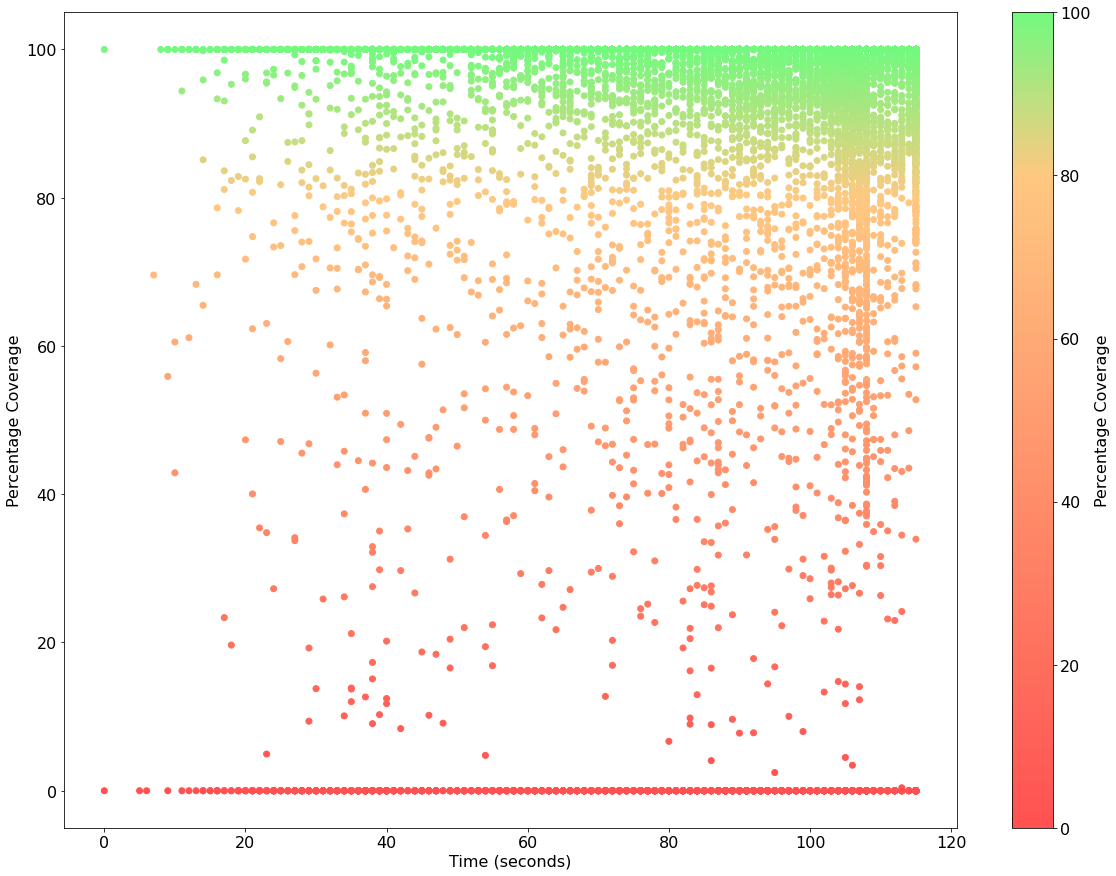

+------------------------------------+---------+
| Spearman's correlation coefficient | p-value |
+------------------------------------+---------+
|               -0.031               |  0.000  |
+------------------------------------+---------+


TypeError: Axes.boxplot() got an unexpected keyword argument 'width'

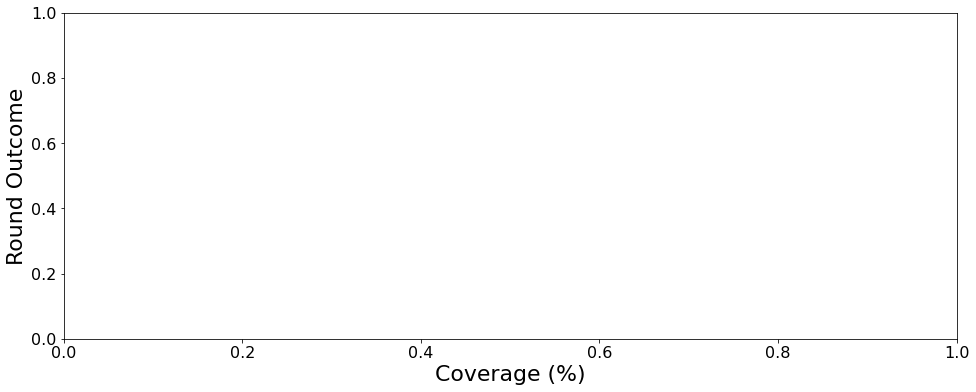

In [101]:
time_coverage_stats(valid_smokes)
win_coverage_stats(valid_smokes)